In [859]:
import pandas as pd
aed_locations = pd.read_csv('aed_locations_coordinates_processed.csv')
card_arrest = pd.read_csv('card_arrest_processed.csv')
hospital_coordinates = pd.read_csv('hospital_coordinates_processed.csv')
removed_AED = pd.read_csv('removed_AED.csv')

deciding which cardiac arrest data to use

We will use all three cardiac problems instead of just the cardiac arrests, because there are very little instances
otherwise. The low amount of instances means that the analysis is too much dependent on coincidence. We asume that the locations where the other cardiac problems occur are similar to the locations where the cardiac arrests occur.

In [860]:
card_arrest_all = card_arrest
#eigenlijk kan je gewoon de tijden nemen, de tijden tot interventie, en dan weet je al of de persoon gered is door een ziekenhuis. Je hoeft dan niet
#meer de afstand tov een ziekenhuis te berekenen, want zo ben je er al. Het probleem is dat er veel NA's zijn.

In [861]:
card_arrest_list = card_arrest['eventType_trip'].unique().tolist()
card_arrest_list

['P011 - Chest pain',
 'P039 - Cardiac problem (other than thoracic pain)',
 'P003 - Cardiac arrest',
 'P008 - Patient with defibrillator - pacemaker',
 'P011 N05 - PIJN OP DE BORST',
 'P011 N01 - PIJN OP DE BORST',
 'P039 N05 - CARDIAAL PROBLEEM (ANDERE DAN PIJN AAN DE BORST)',
 'P039 N03 - CARDIAAL PROBLEEM (ANDERE DAN PIJN AAN DE BORST)',
 'P011 N03 - PIJN OP DE BORST',
 'P039 N01 - CARDIAAL PROBLEEM (ANDERE DAN PIJN AAN DE BORST)',
 'P011 N04 - PIJN OP DE BORST',
 'P003  N01 - HARTSTILSTAND - DOOD - OVERLEDEN',
 'P039 N04 - CARDIAAL PROBLEEM (ANDERE DAN PIJN AAN DE BORST)',
 'P008 N03 - PATIËNT MET DEFIBRILLATOR OF PACEMAKER',
 'P008 N01 - PATIËNT MET DEFIBRILLATOR OF PACEMAKER',
 'P011 N02 - PIJN OP DE BORST',
 'P003  N05 - HARTSTILSTAND - DOOD - OVERLEDEN',
 'P039 - CARDIAAL PROBLEEM (NIET PIJN OP DE BORST)',
 'P011 - PIJN OP DE BORST',
 'P003 - HARTSTILSTAND - DOOD - OVERLEDEN',
 'P008 - PATIËNT MET DEFIBRILLATOR OF PACEMAKER']

In [862]:
#in a real world situation, we would ask if an AED would be useful for all three types of emergencies (P003, P011, P039), or
#only for the cardiac arrests (P003). We will assume that it is only useful for the cardiac arrests, for now.
card_arrest_limited = card_arrest[card_arrest['eventType_trip'].str.contains("P003")]
card_arrest_limited

,eventType_trip,latitude_intervention,longitude_intervention,parsed_T0,parsed_T3,time_difference_seconds,province
9,P003 - Cardiac arrest,50.838080,4.304840,2022-09-06 20:31:42.666252,NaN,NaN,BRU
13,P003 - Cardiac arrest,50.824800,4.381850,2022-09-07 02:36:15.829707,2022-09-07 00:42:25.655123,-6830.174584,BRU
16,P003 - Cardiac arrest,50.838480,4.444410,2022-09-07 12:32:13.510586,2022-09-07 10:49:43.653950,-6149.856636,BRU
33,P003 - Cardiac arrest,50.849480,4.320340,2022-09-08 13:40:50.167814,2022-09-08 11:52:58.220448,-6471.947366,BRU
58,P003 - Cardiac arrest,50.845630,4.308210,2022-09-10 01:14:34.606094,2022-09-10 00:22:34.260161,-3120.345933,BRU
...,...,...,...,...,...,...,...
56248,P003 - HARTSTILSTAND - DOOD - OVERLEDEN,50.937815,4.132712,2023-05-29 23:04:12,NaN,NaN,OVL
56250,P003 - HARTSTILSTAND - DOOD - OVERLEDEN,51.009981,3.899596,2023-05-30 07:46:19,2023-05-30 08:09:56,1417.000000,OVL
56262,P003 - HARTSTILSTAND - DOOD - OVERLEDEN,50.841218,3.902211,2023-05-30 19:05:35,2023-05-30 19:19:42,847.000000,OVL
56270,P003 - HARTSTILSTAND - DOOD - OVERLEDEN,51.127259,3.676424,2023-05-31 07:04:47,2023-05-31 07:21:31,1004.000000,OVL


In [863]:
#create a general function to create plots of the data. Data from two data frames can be plotted.
import folium

def plot_dataFrames(df1, df2,
                   df1_color, df2_color, 
                   df1_tooltip, df2_tooltip,
                   save_path,
                   df1_lat_col='latitude', df1_lon_col='longitude',
                   df2_lat_col='latitude', df2_lon_col='longitude'):
    """
    Plots locations of two data frames on a map.

    Parameters:
    - df1: DataFrame for the first set of interventions.
    - df2: DataFrame for the second set of interventions.
    - df1_lat_col: Name of the latitude column in the first DataFrame.
    - df1_lon_col: Name of the longitude column in the first DataFrame.
    - df2_lat_col: Name of the latitude column in the second DataFrame.
    - df2_lon_col: Name of the longitude column in the second DataFrame.
    - df1_color: Color for the points of the first DataFrame.
    - df2_color: Color for the points of the second DataFrame.
    - df1_tooltip: Tooltip text for the first DataFrame points.
    - df2_tooltip: Tooltip text for the second DataFrame points.
    - save_path: File path to save the resulting HTML map (don't forget to append .html to the name)
    """
    
    # approximately the center of Belgium coordinates
    belgium_center_lat = 50.8503
    belgium_center_lon = 4.3517

    m = folium.Map(location=[belgium_center_lat, belgium_center_lon], zoom_start=8)

    # add all cardiac related intervention locations to the map
    for _, row in df1.iterrows():
        folium.CircleMarker(
            location=[row[df1_lat_col], row[df1_lon_col]],
            radius=1,
            color=df1_color,
            fill=False,
            tooltip=df1_tooltip
        ).add_to(m)

    # add only the cardiac arrests
    for _, row in df2.iterrows():
        folium.CircleMarker(
            location=[row[df2_lat_col], row[df2_lon_col]],
            radius=1,
            color=df2_color,
            fill=False,
            tooltip=df2_tooltip
        ).add_to(m)

    # save the map to an HTML file
    m.save(save_path)
    print(f"Map saved to {save_path}")


In [864]:
plot_dataFrames(card_arrest_all, df2=card_arrest_limited, 
                           df1_lat_col='latitude_intervention', df1_lon_col='longitude_intervention',
                           df2_lat_col='latitude_intervention', df2_lon_col='longitude_intervention',
                           df1_color='blue', df2_color='red', 
                           df1_tooltip='All Cardiac Issues', df2_tooltip='Specifically Cardiac Arrest', 
                           save_path='cardiac_specific_general.html')

Map saved to cardiac_specific_general.html


Timings of intervention

In [865]:
#a substantial amount of cardiac arrests does not contain the time needed for intervention.
#one possible way to generate time needed for intervention is to calculate the distances between the closest hospital and the location of occurrence
#of the cardiac arrest, and then estimate the timing based on this. However, this would likely produce very inaccurate timings, since for example
#not all roads can be traversed at the same speed, and some locations are harder to reach. Therefore, we do not generate any timings values ourselves.
na_count = card_arrest_all['time_difference_seconds'].isna().sum()
print(f"Number of NA values in 'time_difference_seconds': {na_count}")

Number of NA values in 'time_difference_seconds': 5902


In [866]:
#there are negative values present in the timings column. Even if asuming we can simply convert them to positive values, the 
#values are unrealistically high for practically all (more than an hour), so we consider these values as missing.

negative_values = card_arrest[card_arrest_all['time_difference_seconds'] < 0]['time_difference_seconds']

negative_count = negative_values.count()

negative_values_list = negative_values.tolist()

print(negative_values_list)
print(negative_count) #3945 outputted

percentile_99 = card_arrest_all['time_difference_seconds'].quantile(0.99)
percentile_1 = card_arrest_all['time_difference_seconds'].quantile(0.01)
print(percentile_99)
print(percentile_1)

[-3828.336006, -6329.451913, -6374.980376, -6226.958482, -6723.857596, -6622.271904, -6272.545074, -6645.216087, -6830.174584, -6429.657075, -6471.686128, -6149.856636, -6379.23241, -5927.773827, -6539.25461, -5223.564681, -6119.501612, -6251.279365, -6682.99007, -6418.806807, -6678.707167, -6489.133732, -6228.706706, -6257.264308, -6471.947366, -5911.326682, -6828.93195, -6316.898505, -6670.486293, -6133.761079, -6258.396155, -5565.02746, -6608.818931, -6486.533399, -4938.405405, -6433.903585, -6268.497188, -5986.855117, -6551.280324, -6549.674492, -3120.345933, -6677.050234, -6294.936732, -6376.730656, -6512.320656, -6596.656984, -6760.889608, -6578.255646, -5111.783329, -6335.820859, -6583.052696, -5751.110476, -6675.237942, -6424.174979, -6530.920975, -6727.28127, -6588.99302, -6642.967015, -6341.608573, -6732.075481, -5880.029328, -6308.109963, -6583.277528, -6403.207927, -6489.451659, -6189.837555, -6379.216647, -6349.068187, -6496.475852, -6386.091593, -6661.333142, -2446.532987

In [867]:
#convert negative values to missing values (NaN), since these values, even when converted to positive values, are not realistic and
#should therefore not be used any further.
card_arrest_all.loc[card_arrest['time_difference_seconds'] < 0, 'time_difference_seconds'] = np.nan

#considering the average time needed of 14 minutes and 58 seconds and the median value of 12 minutes 26 seconds, we consider the missing values as not
#reached in time by the ambulance.

min_value = card_arrest['time_difference_seconds'].min()
max_value = card_arrest['time_difference_seconds'].max()
median_value = card_arrest['time_difference_seconds'].median()
mean_value = card_arrest['time_difference_seconds'].mean()


print(f"Minimum value: {min_value}")
print(f"Maximum value: {max_value}")
print(f"Median value: {median_value}")
print(f"Average value: {mean_value}")


Minimum value: 32.093
Maximum value: 4820474.0
Median value: 804.891
Average value: 157863.65753508548


In [868]:
#total missing values is 9847
missing_times = card_arrest_all['time_difference_seconds'].isnull().sum()
missing_times

np.int64(9847)

Calculating who is reached in time

In [869]:
#it is hard to find the exact time a person with cardiac arrest can survive without receiving aid. This exact value influences 
#the results of the analysis drastically however. In a real analysis the stakeholder would be contacted to provide an estimate of this time.
#we will asume that a person can go for 3 minutes without receiving aid.

#we remove the cardiac arrests that are reached within 3 minutes, since these do not need an AED in order to be helped. We will use the remaining
#cardiac arrest for the rest of the analysis.

In [870]:
#create table that contains all the cardiac arrests that got reached within 3 minutes. We also create an id variable, to be used
#later on. We simply take the index as the id, the exact value of the id does not matter.
card_arrest_all['card_id'] = card_arrest_all.index

In [871]:
#only 98 could be reached in time
card_arrest_reached = card_arrest_all[card_arrest_all['time_difference_seconds'] < 180] 
card_arrest_reached

,eventType_trip,latitude_intervention,longitude_intervention,parsed_T0,parsed_T3,time_difference_seconds,province,card_id
1735,P039 - Cardiac problem (other than thoracic pain),50.813070,4.381850,2022-12-07 23:13:46.949822,2022-12-07 23:15:38.325266,111.375444,BRU,1735
5275,P011 N01 - PIJN OP DE BORST,50.853468,4.346246,2022-06-15 15:50:20.000000,2022-06-15 15:52:37.000000,137.000000,BRU,5275
6958,P011 - Chest pain,51.257080,4.415370,2022-06-16 08:49:31.000000,2022-06-16 08:51:53.601000,142.601000,ANT,6958
6973,P003 - Cardiac arrest,51.228920,5.077190,2022-06-17 02:04:21.000000,2022-06-17 02:05:54.387000,93.387000,ANT,6973
6988,P011 - Chest pain,51.271110,5.084000,2022-06-17 17:26:46.000000,2022-06-17 17:28:13.035000,87.035000,ANT,6988
...,...,...,...,...,...,...,...,...
54317,P039 - CARDIAAL PROBLEEM (NIET PIJN OP DE BORST),50.930276,3.644738,2023-02-27 16:09:17,2023-02-27 16:10:57,100.000000,OVL,54317
54593,P039 - CARDIAAL PROBLEEM (NIET PIJN OP DE BORST),50.930276,3.644738,2023-03-11 19:58:34,2023-03-11 20:00:35,121.000000,OVL,54593
55148,P011 - PIJN OP DE BORST,51.101943,4.000068,2023-04-05 14:12:26,2023-04-05 14:14:27,121.000000,OVL,55148
55194,P039 - CARDIAAL PROBLEEM (NIET PIJN OP DE BORST),51.101943,4.000068,2023-04-07 11:48:36,2023-04-07 11:50:03,87.000000,OVL,55194


In [872]:
#dan kan je op deze remaining AED's bootstrap toepassen. Dan netwerk maken, van de AED's. hoeft geen echt netwerk te zijn, maar
#in ieder geval mag 1 hartstilstand maar uiteindelijk verbonden zijn met 1 AED, maar 1 AED kan wel verbonden zijn met meerdere hartstilstanden.

Calculate which AED's are valid

In [873]:
#people can run at about 10 km per hour, so the distance ran in 3 minutes would be 500 meter. Since it's unlikely that you can run in a straight line
#from occurrence of cardiac arrest to AED (e.g. the AED is located on the other side of the building it is attached to), we add another 15% in time
#needed to reach the AED. This translates to to the total running distance to be approximately 435 meter. Since the person would also need to run back
#and forth, the distance between cardiac arrest and AED needs to be 217.5 meter or less.

minutes = 3
X = (((10000 / 60) * minutes) / 1.15) / 2
X

217.3913043478261

In [1088]:
#change the name to avoid confusion
aed_locations = aed_locations.rename(columns={'id': 'aed_id'})
aed_locations

,aed_id,address,number,municipality,latitude,longitude,postal_code,province
0,71.0,Place Saint - Lambert,0,Liège,50.750721,5.933967,4020.0,Liège
1,72.0,Rue du Doyard,0,Lierneux,50.285043,5.785950,4990.0,Liège
2,73.0,Fond Saint Servais,0,Liège,50.646765,5.570987,4000.0,Liège
3,74.0,Rue des Prémontrès,12,Liège,50.638047,5.574046,4020.0,Liège
4,76.0,Rue du Parc,1,Jehay,50.577233,5.323038,4540.0,Liège
...,...,...,...,...,...,...,...,...
11644,16654.0,Farnières,4,Grand Halleux,50.310813,5.880418,6698.0,Liège
11645,16660.0,Chaussée de Marche,799,Wierde,50.426430,4.929522,5100.0,Namur
11646,16661.0,Nekkerspoel-Borcht,19,Mechelen,51.025217,4.504148,2800.0,Antwerpen
11647,16664.0,Nieuwe Dreef,17,Lokeren,51.097802,3.911744,9160.0,Oost-Vlaanderen


In [875]:
#to calculate the distances, we use haversine formula, which accounts for the Earth's curvature.

Below cell is the solution to the problem of how to calculate all the distances between the cardiac arrests and the AED's, and how to decide whether or not an AED is valid. It is recommended that the explanation in the report is read first, before reading the code.
For how we define an AED to be valid, see the report.
Brute force (i.e. simply calculating ALL the distances possible) was not an option, since it would take practically infinite amount of time to do so. Therefore, a more clever solution was used. Details are available in the report. Two things were used to speed up the calculations:
*A KDTree was constructed for the AED locations, which makes the lookup of distances a lot faster since then not all AED's need to be queried
*Rules were defined, which guarantee that if the AED follows these rules, it is a valid AED that is performing well.

In [1090]:
import numpy as np
from scipy.spatial import cKDTree
from geopy.distance import great_circle

# haversine function to calculate the distance between two points on Earth's surface
def haversine(coord1, coord2):
    return great_circle(coord1, coord2).meters

# extract coordinates and IDs from the tables
arrest_coords = np.array(list(zip(card_arrest_all['latitude_intervention'], card_arrest_all['longitude_intervention'])))
arrest_ids = card_arrest_all['card_id'].values

aed_coords = np.array(list(zip(aed_locations['latitude'], aed_locations['longitude'])))
aed_ids = aed_locations['aed_id'].values

# convert degrees to radians
arrest_coords = np.radians(arrest_coords)
aed_coords = np.radians(aed_coords)

# build a KDTree for AED locations
aed_tree = cKDTree(aed_coords)

# initialize an empty list to store the table entries. The table will have three columns: card_id, aed_id and distance.
table_entries = []

# populate the table
for arrest_index, arrest_coord in enumerate(arrest_coords):
    arrest_id = arrest_ids[arrest_index]
    
    # find all AEDs within distance X, with X defined earlier. Use the KDTree to query. The coordinates need to be in radians for this step, since
    #the query_ball_point returns simple euclidean distance
    # dividing by 6371000 makes it so that the distance in meters gets converted to a distance in radians
    aeds_within_X = aed_tree.query_ball_point(arrest_coord, X / 6371000)

    for aed_index in aeds_within_X:
        aed_coord = aed_coords[aed_index]
        #haversine requires degrees (so original coordinates), convert it back
        distance = haversine(np.degrees(arrest_coord), np.degrees(aed_coord))
        aed_id = aed_ids[aed_index]
        table_entries.append((distance, arrest_id, aed_id))

# convert the table into a data frame for easier manipulation
columns = ['distance', 'card_id', 'aed_id']
table_df = pd.DataFrame(table_entries, columns=columns)

# filter the table to keep only the closest AED for each cardiac arrest
filtered_table_df = table_df.loc[table_df.groupby('card_id')['distance'].idxmin()]


# remove the AED's connected to a cardiac arrest that already got reached in time by a professional
filtered_table_df_cleaned = filtered_table_df[~filtered_table_df['card_id'].isin(card_arrest_reached['card_id'])]

# add the removed AED's that were already reached by a professional to the removed_AED table, with their corresponding reason
rows_to_remove = filtered_table_df[filtered_table_df['card_id'].isin(card_arrest_reached['card_id'])]
aed_rows_to_remove = aed_locations[aed_locations['aed_id'].isin(rows_to_remove['aed_id'])]
aed_rows_to_remove['reason'] = 'already_reached'
aed_rows_to_remove = aed_rows_to_remove[['aed_id', 'reason', 'province', 'municipality']] #we only want to add these columns

removed_AED = pd.concat([removed_AED, aed_rows_to_remove[['aed_id', 'reason']].rename(columns={'aed_id': 'id'})], ignore_index=True)



# some AED's might occur more than once, so take the unique values.
valid_aed_ids = filtered_table_df_cleaned['aed_id'].unique()

# the remaining AEDs in the filtered table are valid. The rest is considered underperforming.
valid_aeds = aed_locations[aed_locations['aed_id'].isin(valid_aed_ids)]

#we can also get the amount of cardiac problems covered by the AED's by simply counting the length of the table
interventions_covered = len(filtered_table_df_cleaned)

C:\Users\eloua\AppData\Local\Temp\ipykernel_20008\1239189605.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aed_rows_to_remove['reason'] = 'already_reached'


In [877]:
#4648 AED's are "performing" well, out of the approximately 11 000 valid AED's tested in this step. That's around 0.2% 
#of the tested AED's (using as value for X 217.5 meter)
len(valid_aeds)

4657

In [1091]:
#13205 cardiac arrests are covered (which are not covered by the hospitals)
interventions_covered

13205

In [1107]:
#put it in a tuple, is for later, to put it in a plot
original_real_output = (len(valid_aeds), interventions_covered)
original_real_output

(4657, 13205)

In [878]:
#add the underperforming AED's to the removed_AED data frame

underperforming_aeds = aed_locations[~aed_locations['aed_id'].isin(valid_aeds['aed_id'])]
underperforming_aeds['reason'] = 'underperforming'
underperforming_aeds = underperforming_aeds[['aed_id', 'reason', 'province', 'municipality']]
underperforming_aeds = underperforming_aeds.rename(columns = {'aed_id': 'id'})

removed_AED = pd.concat([removed_AED, underperforming_aeds], ignore_index=True)
removed_AED

C:\Users\eloua\AppData\Local\Temp\ipykernel_20008\3796858515.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  underperforming_aeds['reason'] = 'underperforming'


,id,reason,province,municipality
0,7323.0,address_missing,Limburg,Neerpelt
1,7467.0,address_missing,Luxembourg,Saint-Hubert
2,9010899.0,address_missing,NaN,NaN
3,9010900.0,address_missing,NaN,NaN
4,1412.0,not_available,Hainaut,La Hestre
...,...,...,...,...
10585,16653.0,underperforming,Limburg,Sint-Truiden
10586,16654.0,underperforming,Liège,Grand Halleux
10587,16660.0,underperforming,Namur,Wierde
10588,16661.0,underperforming,Antwerpen,Mechelen


In [879]:
#now, in the case that there are AED which cover a cardiac arrest that is already reached by a professional, it will be so that
#this instance will be present twice in the removed_AED data frame, once with 'reason' value 'underperforming', once with 'reason' value
#'already_reached'. We will remove the instance for which the value is 'underperforming', since then the instance is only present once, with the 
#correct reason for removal.

# sort the DataFrame so that 'already_reached' comes before 'underperforming'
removed_AED = removed_AED.sort_values(by=['id', 'reason'], ascending=[True, True])

# drop duplicates, keeping the first occurrence (which will be 'already_reached')
removed_AED_cleaned = removed_AED.drop_duplicates(subset=['id', 'province', 'municipality'], keep='first')
removed_AED_cleaned
#there was no overlap for X = 217.5 so nothing changed.

,id,reason,province,municipality
753,13.0,missing_coordinates,Hainaut,SOIGNIES
754,70.0,missing_coordinates,Liège,Ayeneux
3598,71.0,underperforming,Liège,Liège
755,75.0,missing_coordinates,Liège,Harzé
3599,76.0,underperforming,Liège,Jehay
...,...,...,...,...
10112,9015881.0,underperforming,Oost-Vlaanderen,OOSTAKKER
10113,9015882.0,underperforming,Oost-Vlaanderen,OOSTAKKER
10114,9015883.0,underperforming,Antwerpen,KAPELLEN
10115,9015884.0,underperforming,Antwerpen,HERENTHOUT


creating synthetic instances to test our results with

We want to create some sort of testing set, in order to test the results of the analysis. If we simply test on the training set,
we risk obtaining a solution that overfits on the training set, and would perform poorly on new data (i.e. future occurrences of cardiac arrests)

In [881]:
#KDE sampling and poisson based sampling were also used to create synthetic instances, however the results were very unrealistic,
#based on a plotting of synthetic instances and original instances. Only the code for a K-means solution is shown, since it was the only one that
#gave more or less realistic results.
from sklearn.cluster import KMeans

#perturbation of 0.01 means the synthetic instance occurs about a couple streets further, which is what we want
#we take a very large amount of clusters, in order to avoid just creating synthetic instances that match our future clustering analysis and thus 
#providing us with artificially high performance metrics, simply because it matches the used analysis method. A high amount of clusters also matches
#the the observed data well
np.random.seed(11)
def combined_sampling(df, num_samples, perturbation_std=0.01):
    coords = df[['latitude_intervention', 'longitude_intervention']].values
    kmeans = KMeans(n_clusters=2000).fit(coords)
    
    # perturbation around cluster centers
    new_data = []
    for center in kmeans.cluster_centers_:
        for _ in range(num_samples // len(kmeans.cluster_centers_)):
            lat_noise = np.random.normal(0, perturbation_std)
            lon_noise = np.random.normal(0, perturbation_std)
            new_data.append({
                'latitude_intervention': center[0] + lat_noise,
                'longitude_intervention': center[1] + lon_noise
            })
    
    return pd.DataFrame(new_data)

df_synthetic = combined_sampling(card_arrest, num_samples=56000, perturbation_std=0.01)

In [882]:
#the plot shows that the synthetic data created using this method matches the observed data well. However, we will
#still teste whether or not the synthetic data is good by comparing the performance of the AED's on this synthetic dataset to
#the performance on the real dataset.
#This data can be used later, in order to test the performance of our newly located AED's.

plot_dataFrames(card_arrest, df_synthetic, 'red', 'orange', 'Original Cardiac Intervention', 'Synthetic Cardiac Intervention',
                'synthetic_Kmeans.html', 'latitude_intervention', 'longitude_intervention', 'latitude_intervention',
                'longitude_intervention')

Map saved to synthetic_Kmeans.html


In [883]:
df_synthetic.to_csv('df_synthetic_Kmeans.csv', index=False)

Another synthetic dataset is created, using a much simpler method. The goal of our synthetic dataset is to pretend that the cardiac arrest occurred somewhere else, randomly, so for example a street further, while maintaining the structure of the original data (i.e. the density and the distribution of the datapoints). We can do this by simply adding or subtracting from the coordinates directly, instead of having to rely on clustering methods, which distort the density and distribution.

In [884]:
#using this to see how much the coordinates should be ofset using a uniform distribution
#0.0015 approximately a street further, which is what we want to do on average, so [-0.0030, 0.0030] is the appropriate range to use to randomly
#add or subtract to the existing coordinates in our dataset.

#the plot shows the different locations.
testset = pd.DataFrame({
    'latitude': [50.916854, 50.918354, 50.919854, 50.915354, 50.921354], #increments of 0.0015
    'longitude': [4.307399, 4.308899, 4.310399, 4.305899, 4.321899]
})


m = folium.Map(location=[belgium_center_lat, belgium_center_lon], zoom_start=8)

# add original cardiac arrest locations to the map
for _, row in testset.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=3,
        color='blue',
        fill=False,
        tooltip='Test Coordinate'
    ).add_to(m)


m.save('coord_testing.html')

In [885]:
#cardiac arrests randomly moved by about a street [-0.003, 0.003] in longitude and latitude. By doing this, we essentially
#maintain the same structure of the original data (density, distribution). We only change the exact locations of occurrence, for example a cardiac
#arrest occurring a street further than it did in the original data. This is to make sure our solution doesn't overfit on the original data.
synthetic_uniform = card_arrest_all.copy()

#generate random values to add/subtract from both latitude and longitude
random_offsets = np.random.uniform(-0.003, 0.003, size=(len(card_arrest_all), 2))

#apply the offsets to the latitude and longitude
synthetic_uniform['latitude_intervention'] += random_offsets[:, 0]
synthetic_uniform['longitude_intervention'] += random_offsets[:, 1]
synthetic_uniform

,eventType_trip,latitude_intervention,longitude_intervention,parsed_T0,parsed_T3,time_difference_seconds,province,card_id
0,P011 - Chest pain,50.876840,4.389529,2022-09-06 14:51:41.968677,NaN,NaN,BRU,0
1,P011 - Chest pain,50.898689,4.361082,2022-09-06 15:08:52.857352,2022-09-06 14:05:04.521346,NaN,BRU,1
2,P011 - Chest pain,50.853718,4.426376,2022-09-06 16:36:15.795918,2022-09-06 14:50:46.344005,NaN,BRU,2
3,P011 - Chest pain,50.809934,4.348741,2022-09-06 17:14:30.554547,2022-09-06 15:28:15.574171,NaN,BRU,3
4,P039 - Cardiac problem (other than thoracic pain),50.869041,4.359799,2022-09-06 18:21:26.211055,NaN,NaN,BRU,4
...,...,...,...,...,...,...,...,...
56279,P039 - CARDIAAL PROBLEEM (NIET PIJN OP DE BORST),50.977494,3.984062,2023-05-31 19:47:06,2023-05-31 19:56:44,578.0,OVL,56279
56280,P039 - CARDIAAL PROBLEEM (NIET PIJN OP DE BORST),51.133708,4.111837,2023-05-31 20:41:28,2023-05-31 20:53:46,738.0,OVL,56280
56281,P003 - HARTSTILSTAND - DOOD - OVERLEDEN,50.894542,3.857784,2023-05-31 20:45:48,2023-05-31 20:57:17,689.0,OVL,56281
56282,P039 - CARDIAAL PROBLEEM (NIET PIJN OP DE BORST),50.967822,3.759990,2023-05-31 21:38:03,2023-05-31 21:54:16,973.0,OVL,56282


In [886]:
synthetic_uniform.to_csv('synthetic_uniform.csv', index=False)

In [887]:
#comparing the original instances to the synthetic instances generated using the uniform distribution

plot_dataFrames(card_arrest_all, synthetic_uniform,
                   'red', 'orange', 
                   'Original Cardiac Arrest', 'Synthetic Cardiac Arrest',
                   'cardiac_arrests_map_belgium_uniform.html',
                   df1_lat_col='latitude_intervention', df1_lon_col='longitude_intervention',
                   df2_lat_col='latitude_intervention', df2_lon_col='longitude_intervention')

Map saved to cardiac_arrests_map_belgium_uniform.html


The plot shows that the synthetic data created using the uniform method matches the observed data well. However, we will still teste whether or not the synthetic data is good by comparing the performance of the original AED setup on this synthetic dataset to the performance on the real dataset. The performance on the synthetic instances should be similar to the performance on the real dataset, if the synthetic dataset is good. This synthetic data can be used later, in order to test the performance of our newly located AED's.

In [888]:
#need to add card_id variable, otherwise the function doesn't work, the exact values aren't important
df_synthetic['card_id'] = df_synthetic.index
df_synthetic

,latitude_intervention,longitude_intervention,card_id
0,51.237012,4.410876,0
1,51.203597,4.414996,1
2,51.221969,4.423797,2
3,51.211228,4.414077,3
4,51.223788,4.415227,4
...,...,...,...
55995,51.233265,4.065935,55995
55996,51.236395,4.033237,55996
55997,51.228742,4.077923,55997
55998,51.219511,4.077468,55998


In [1106]:
def find_closest_aeds_count(X, card_arrest, aed_locations):
    """
    Finds the closest AED for each cardiac arrest within a specified distance X.

    Parameters:
    X: The maximum distance (in meters) to consider for finding AEDs near a cardiac arrest.
    card_arrest: DataFrame containing the cardiac arrest data with 'latitude_intervention', 
                                    'longitude_intervention', and 'card_id' columns.
    aed_locations: DataFrame containing the AED location data with 'latitude', 'longitude', 
                                  and 'aed_id' columns.

    Returns:
    amount_valid: the amount of AEDs that would be valid using this combination of cardiac arrest data 
                  (synthetic or not) and setup of AEDs.
    """

    # extract coordinates and IDs from the input data frames
    arrest_coords = np.array(list(zip(card_arrest['latitude_intervention'], card_arrest['longitude_intervention'])))
    arrest_ids = card_arrest['card_id'].values

    aed_coords = np.array(list(zip(aed_locations['latitude'], aed_locations['longitude'])))
    aed_ids = aed_locations['aed_id'].values

    # convert coordinates to radians for correct KDTree usage
    arrest_coords = np.radians(arrest_coords)
    aed_coords = np.radians(aed_coords)
    
    # build a KDTree for AED locations, using the converted coordinates (so in radians)
    aed_tree = cKDTree(aed_coords)

    table_entries = []

    # populate the table with AEDs within the distance X for each cardiac arrest
    for arrest_index, arrest_coord in enumerate(arrest_coords):
        arrest_id = arrest_ids[arrest_index]
        
        # find all AEDs within distance X
        aeds_within_X = aed_tree.query_ball_point(arrest_coord, X / 6371000) #it needs to be in radians for this step

        # append all AEDs within the distance X to the table
        for aed_index in aeds_within_X:
            aed_coord = aed_coords[aed_index]
            distance = great_circle(np.degrees(arrest_coord), np.degrees(aed_coord)).meters #great_circle makes use of degrees, so convert back
            aed_id = aed_ids[aed_index]
            table_entries.append((distance, arrest_id, aed_id))

    # convert the table into a data frame for easier manipulation
    columns = ['distance', 'card_id', 'aed_id']
    table_df = pd.DataFrame(table_entries, columns=columns)

    # filter the table to keep only the closest AED for each cardiac arrest
    filtered_table_df = table_df.loc[table_df.groupby('card_id')['distance'].idxmin()]

    # we are only interested in the amount of valid AEDs here
    amount_valid = len(filtered_table_df['aed_id'].unique())
    interventions_covered = len(filtered_table_df)

    return amount_valid, interventions_covered


original_syntheticUniform_output = find_closest_aeds_count(X, synthetic_uniform, aed_locations)
original_syntheticUniform_output

(4810, 11736)

In [1086]:
aed_locations = pd.read_csv('aed_locations_coordinates_processed.csv')

4810 AED's are valid using the uniform distribution, which comes close to the 4657 of the real dataset. This indicates that the synthetic dataset created by using random uniform changes in coordinates is realistic.

In [1105]:
original_syntheticKmeans_output = find_closest_aeds_count(X, df_synthetic, aed_locations)
original_syntheticKmeans_output

(3078, 4021)

3078 AED's are valid using the synthetic data from the K-means generation, compared to the 4657, which confirms that this method of data generation is not as realistic.

Finding the new locations

Now we need to find the locations where to place the AED's we want to reallocate.

In [813]:
#first we plot to see where the valid AED's are located, perhaps we can learn something from this

plot_dataFrames(card_arrest, valid_aeds,
                   'red', 'green', 
                   'Cardiac Arrest', 'Valid AED',
                   'valid_aeds.html',
                   df1_lat_col = 'latitude_intervention', df1_lon_col = 'longitude_intervention')

Map saved to valid_aeds.html


In [814]:
#as expected, the valid aed's lie in or close to a city, where the population density is higher. There are also no valid AED's in the less densely
#populated south of Walonia. Therefore, to find the new locations for the AED's, we make use of a method that can make use of the
#density of clusters, since density of the occurrence of cardiac arrests plays a major role in whether or not an AED is useful.

There is a limited amount of AED's compared to the overall size that should be covered. Identifying locations where
cardiac arrests occur more often compared to the rest of Belgium and placing AED's there seems like the most valid strategy.
We make use of 2 rules in order to identify the spots where an AED would likely perform well:
-density: for a cluster to be valid, the density needs to be above a certain treshold. This is because density is the most important factor when
considering to place an AED somewhere, since density decides whether or not the AED will actually be close to the occurrence (since we cannot know the exact location of an occurrence in the future). It doesn't matter if the method finds a perfectly shaped cluster, if all the cardiac arrests are far from each other placing effective AED's will not be possible.
-minimum number of occurrences per cluster: in order to avoid finding clusters consisting of cardiac arrests which lie coincidentally close to each other without there being a real pattern, a minimum amount of cardiac arrests needs to be in the cluster. This minimum amount should be small, since the chance that two or more lie close to each other is small anyway.

In [815]:
#remove the cardiac arrests of people already saved. These are the ones covered by the hospitals, and the ones covered by the
#valid AED'. We do not need to cover these occurrences with AED's, so they need to be taken out of the dataset, otherwise they will still influence
#the outcome

#combine the card_id values from filtered_table_df and card_arrest_reached, these are the ones already covered by an existinf AED or a hospital
combined_ids = pd.concat([filtered_table_df['card_id'], card_arrest_reached['card_id']])

filtered_card_arrest_all = card_arrest_all[~card_arrest_all['card_id'].isin(combined_ids)]
filtered_card_arrest_all

,eventType_trip,latitude_intervention,longitude_intervention,parsed_T0,parsed_T3,time_difference_seconds,province,card_id
0,P011 - Chest pain,50.877980,4.392290,2022-09-06 14:51:41.968677,NaN,NaN,BRU,0
1,P011 - Chest pain,50.895780,4.358170,2022-09-06 15:08:52.857352,2022-09-06 14:05:04.521346,NaN,BRU,1
3,P011 - Chest pain,50.809380,4.347430,2022-09-06 17:14:30.554547,2022-09-06 15:28:15.574171,NaN,BRU,3
5,P039 - Cardiac problem (other than thoracic pain),50.788590,4.315430,2022-09-06 18:33:18.236746,2022-09-06 16:49:31.278264,NaN,BRU,5
12,P011 - Chest pain,50.831310,4.298910,2022-09-07 01:38:26.232202,2022-09-06 23:47:41.016115,NaN,BRU,12
...,...,...,...,...,...,...,...,...
56279,P039 - CARDIAAL PROBLEEM (NIET PIJN OP DE BORST),50.980111,3.982742,2023-05-31 19:47:06,2023-05-31 19:56:44,578.0,OVL,56279
56280,P039 - CARDIAAL PROBLEEM (NIET PIJN OP DE BORST),51.131239,4.111499,2023-05-31 20:41:28,2023-05-31 20:53:46,738.0,OVL,56280
56281,P003 - HARTSTILSTAND - DOOD - OVERLEDEN,50.896206,3.856032,2023-05-31 20:45:48,2023-05-31 20:57:17,689.0,OVL,56281
56282,P039 - CARDIAAL PROBLEEM (NIET PIJN OP DE BORST),50.965585,3.758418,2023-05-31 21:38:03,2023-05-31 21:54:16,973.0,OVL,56282


In [816]:
#ook het aantal AED's dat we nu kunnen gebruiken bepalen. is in principe len(removed_AED), maar eigenlijk niet, want
#van sommige weten we niet of ze goed performen, dus zal moeten filteren nog.

We will only reallocate the AED's for which we actually know they are not performing well. We cannot say we need to move an AED
if we do not know the coordinates, or if the address is missing. We will also move the ones that are not available, although in a real context
one would have needed to verify why these are not available (because if they are for example privately owned, we cannot realocate them).

In [817]:
unique_reasons = removed_AED['reason'].unique()
unique_reasons

array(['missing_coordinates', 'underperforming', 'already_reached',
       'not_available', 'address_missing'], dtype=object)

In [818]:
remove_reasons = ['underperforming', 'not_available', 'already_reached']
aeds_to_move = removed_AED[removed_AED['reason'].isin(remove_reasons)]
aeds_to_move

,id,reason,province,municipality
3598,71.0,underperforming,Liège,Liège
3599,76.0,underperforming,Liège,Jehay
3600,101.0,underperforming,Bruxelles-Brussel,Brussel
3601,117.0,underperforming,Limburg,Sint-Pieters-Voeren
3602,118.0,underperforming,Limburg,Moelingen
...,...,...,...,...
10111,9015880.0,underperforming,Oost-Vlaanderen,OOSTAKKER
10112,9015881.0,underperforming,Oost-Vlaanderen,OOSTAKKER
10113,9015882.0,underperforming,Oost-Vlaanderen,OOSTAKKER
10114,9015883.0,underperforming,Antwerpen,KAPELLEN


In [ ]:
#nu nog een methode vinden om ze optimaal te plaatsen,
#je kan de originele data en de bootstrap gebruiken als performance metric
#je kan de regels over goede clusters gebruiken
#maar dan nog, hoe bepaal je een goeie exacte locatie? gewoon random droppen in de cluster, of in de vorm van een rooster ofzo? of binnen elke cluster
#een slimme verdeling volgen?

#we willen sowieso boven een bepaalde density raken. dus dat als eerste stap. Dan kan je binnen elke cluster kijken hoe verdelen. bij deze tweede
#stap kan je gebruik maken van performance criterium? Je kan het aantal AED's per cluster toewijzen op basis van het aantal cardiac arrests in de 
#cluster, maar het is niet noodzakelijk zo dat dat ook effectief de beste oplossing is.

#we kunnen sowieso searchen over een aantal waardes voor de params, bv de optimale density.
#meerdere benaderingen (nadat de clusters gevonden zijn):
#-k-means opnieuw doen binnen elke cluster, voor elke AED die toegewezen is aan de cluster (maar dan moeten we al een bepaald aantal toewijzen 
#aan elke cluster, en hoe doe je dat?)
#-Maximal Coverage Location Problem (MCLP): we weten dat elke AED een bepaalde area bedekt. We kunnen de AED's zodanig plaatsen dat maximaal oppervlak
#van de cluster is gedekt. Dat zal lijken alsof we een rooster maken van AED's dan (-> misschien kan je dit combineren met de density binnen de cluster
#zelf nog eens, of met een clustering methode)
#-Incident Frequency Weighted Centroid: If some locations within a cluster have had more incidents than others, you could use a weighted centroid where
#locations with more incidents pull the AED placement closer to them.
#

In [ ]:
#op basis van de resultaten van de dbscan lijkt een methode waar het grootste oppevlak wordt bedekt de beste, binnen in 
#de cluster. de vorm die maximaal bedekt moet worden is dan een cirkel, met als middlepunt de centroid van de cluster, en als straat
#de afstand tot het verste punt. (misschien niet de beste oplossing dit).

In [ ]:
#eerst bepalen welke initiele clustering methode toepassen.

We use DBSCAN for our initial clustering method. This is so because it is able to make use of both our rules, namely the clusters are above a certain density, and the clusters contain a minimum amount of instances.

In [819]:
#calculate an approximate distance expressed in degrees, instead of meter. We can use this value directly in DBSCAN as our 
#epsilon.
#we base our distance on the distance used to judge whether an AED is within reach of a cardiac arrest, although for this analysis, this does not need
#to be the case.
import math

radians = math.radians(50.8503) #50.8503 is approximately the latitude of Belgium
cosine_value_latitude = math.cos(radians)
cosine_value_latitude

#we make an approximation of the distance converted to degrees, since we need to input epsilon. Since the distance is small it doesn't matter anyway
#if there is a small error in it.
distance_latitude = X/111320
distance_longitude = X/(111320 * cosine_value_latitude)

approximate_distance = (distance_latitude + distance_longitude)/2
approximate_distance

0.0025229954708592306

In [820]:
#there is no definite answer on how big epsilon should be, i.e. how great the distance between two cardiac arrests should be for them to be 
#considered belonging to the same cluster. Make the distance too big and we end up with useless clusters that contain too many instances too far from
#each other. Too small and we end up with small clusters that are likely going to result in AED locations that are "overfitted".
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt


coordinates = filtered_card_arrest_all[['latitude_intervention', 'longitude_intervention']].values


# parameters to tune
epsilon = approximate_distance
min_samples = 3  # minimum number of instances in a cluster

#euclidian distance will be accurate enough for our purposes, since the distances are small they are not affected significantly by Earth's curvature
db = DBSCAN(eps=epsilon, min_samples=min_samples, metric='euclidean').fit(coordinates)

# add cluster labels to your DataFrame
filtered_card_arrest_all['cluster'] = db.labels_
labels = db.labels_


# create a data frame to hold labels and their counts
labels_df = pd.DataFrame(labels, columns=['cluster'])
labels_df['cluster'] = labels_df['cluster'].astype(str)  # convert to string for easier handling

# count occurrences of each cluster label
cluster_counts = labels_df['cluster'].value_counts()

# exclude noise points, which are labeled as '-1'
cluster_counts = cluster_counts[cluster_counts.index != '-1']

# count how many clusters have each size
size_counts = cluster_counts.value_counts().sort_index()

C:\Users\eloua\AppData\Local\Temp\ipykernel_20008\260875900.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_card_arrest_all['cluster'] = db.labels_


In [821]:
cluster_counts

cluster
19      382
12      273
13      207
244     198
3016    186
       ... 
3432      3
3434      3
3436      3
3437      3
3439      3
Name: count, Length: 3522, dtype: int64

In [892]:
#create a plot to review the solution. Can't use the function, since a different color per cluster is used.
import random

# Function to generate a random color
def random_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))

belgium_center = [50.8503, 4.3517]

#note that it is stored to 'd', this is because we want to plot the reallocated AED's on it later
d = folium.Map(location=belgium_center, zoom_start=8)

# generate random colors for each cluster
unique_clusters = set(filtered_card_arrest_all['cluster'])
cluster_colors = {}
for cluster_label in unique_clusters:
    if cluster_label != -1:  # give noise black
        cluster_colors[cluster_label] = random_color()
    else:
        cluster_colors[cluster_label] = 'black'



# add points to the map, colored by cluster
for _, row in filtered_card_arrest_all.iterrows():
    cluster_label = row['cluster']
    
    #if cluster_label != -1:
    color = cluster_colors[cluster_label]
    
    folium.CircleMarker(
        location=[row['latitude_intervention'], row['longitude_intervention']],
        radius=1,
        color=color,
        fill=False,
        popup=f"Cluster: {cluster_label}"
        ).add_to(d)
        

d.save('dbscan_plus_card_arrest.html')

Brussels contains a lot of instances in clusters. Notice however that the center of Brussels city contains almost no instances, while for example Schaerbeek does contain instances. This aligns with the fact that the center already has a lot of AED's, thus not needing any more there.

In [825]:
num_clusters = len(set(labels) - {-1})
num_clusters

3522

In [826]:
with open('size_counts_output.txt', 'w') as f:
    f.write(size_counts.to_string())

In [949]:
#25130 out of 56284 get assigned to a cluster.
non_noise_count = np.sum(labels != -1)
non_noise_count

np.int64(25130)

In [1028]:
#we will assign a proportional amount of AED's to each cluster, i.e. the amount of AED's that is proportional to the size of the
#cluster.

# calculate proportional allocation
total_points_in_clusters = cluster_counts.sum()
proportional_aeds = (cluster_counts / total_points_in_clusters * total_aeds).round().astype(int)

In [951]:
proportional_aeds.sum()

np.int64(11433)

In [952]:
cards_per_AED = non_noise_count / len(aeds_to_move)
cards_per_AED

np.float64(3.2379847957737407)

In [1044]:
#there are 3672 AED's too many attributed to clusters. This is partly because of the rounding done when calculating how many AED's each
#cluster should get, e.g. 0.7 AED's get attributed which gets rounded up to 1. However, the main cause is the fact that on average, an AED should
#be placed per 3.2380 cardiac arrests, but the smallest clusters in our dataset is of size 3 (and those get 1 AED), which results in too many AED's
#attributed.
#There are multiple ways to account for this. One way would be to simply remove the minimum amount required to form a cluster to 4, essentially 
#eliminating all clusters of size 3. Another would be to take AED's from all clusters that have more than 1 AED, in order to guarantee that these
#smaller clusters have their AED.
#note that this problem does not always occur, hence why the code was not changed to account for this earlier.
total_aeds_proportional = proportional_aeds.sum()

count_difference = aeds_to_move.shape[0] - total_aeds_proportional
count_difference

np.int64(0)

In [831]:
#there are two ways to deal with this: either you change the rounding, so that it only gets rounded up if the value is for
#example 0.55 or higher, or you simply take AED's assigned to clusters back. By changing the rounding, it is especially the smaller clusters
#that get punished (since they potentially go from for example 2 AED's to 1, or even 1 to 0), while for the bigger clusters the difference would not
#be noticeable. Therefore the second method is used, specifically taking from the bigger clusters, where it probably does not matter much anyway.

In [832]:
#it is also possible that there are some AED's that do not get alocated, due to rounding. We can use the same methods here,
#either changing the rounding to for example round up at 0.45, which would benefit smaller clusters, or to reallocate them to bigger clusters.
#The below code works for both cases (there being a surplus of AED's and there being too many AED's appointed to clusters).

In [ ]:
#we use a combination of methods: round up, and then also reduce from the biggest groups, and remove some of the smaller groups

In [1030]:
#the value needs to be 0.7 in order to be rounded up now.
proportional_aeds = (cluster_counts / total_points_in_clusters * total_aeds - 0.2).round().astype(int)

In [1031]:
#removing the remaining missassigned AED's

# identify the 700 largest values.  We will change the number assigned based on these 700 largest clusters.
largest_700_indices = proportional_aeds.nlargest(700).index
largest_700_values = proportional_aeds.loc[largest_700_indices]

# calculate the proportional shares
total700_sum = largest_700_values.sum()
proportions = (largest_700_values / total700_sum) * abs(count_difference)

# round the shares to integers (again to avoid assigning .23123 AED's to a cluster or something)
int_proportions = np.floor(proportions).astype(int)


if count_difference > 0:
    proportional_aeds.loc[largest_700_indices] += int_proportions
else:
    proportional_aeds.loc[largest_700_indices] -= int_proportions


# calculate the remainder
remainder = aeds_to_move.shape[0] - proportional_aeds.sum()


#we will subtract 1 from the remainder amount of smallest groups (in practice this means eliminating these groups)
if remainder < 0:
    smallest_groups = cluster_counts.nsmallest(abs(remainder)) #
    proportional_aeds.loc[smallest_groups.index] -= 1 #nog een if remainder < 0 aan toevoegen?
else:
    proportional_aeds.loc[0] += remainder #simply add all the remaining to the biggest group if it is positive

In [1061]:
#we need to mark the clusters for which there are zero AED's appointed to now to -1, otherwise this results in problems in the
#code down below.

#cluster column is int type, so convert it
zero_aed_clusters = proportional_aeds[proportional_aeds == 0].index.astype(int)

filtered_card_arrest_all['cluster'] = filtered_card_arrest_all['cluster'].replace(zero_aed_clusters, -1)

17851
18934


C:\Users\eloua\AppData\Local\Temp\ipykernel_20008\4187627145.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_card_arrest_all['cluster'] = filtered_card_arrest_all['cluster'].replace(zero_aed_clusters, -1)


Now that we have the clusters and the number of AED's appointed to each cluster, we need to decide where exactly in the cluster the AED should be placed. The method is different for small clusters, for which only 1 AED was appointed, and bigger clusters, for which 2 or more AED's were appointed. For small clusters, we simply place the AED at the centroid of the cluster. For bigger clusters, we try to place the AED's in such a way that they cover as much area as possible. We make use of a greedy algorithm for this. Detailed explanation is present in the report.

In [1062]:
from scipy.spatial import distance

def calculate_centroid(df):
    """ Calculate centroid of a cluster """
    return df[['latitude_intervention', 'longitude_intervention']].mean().values

#for clusters with only a few cardiac arrests we simply place the AED at the centroid
def place_aeds_centroid(cluster_df, num_aeds):
    """ Place AED at the centroid for smaller clusters """
    centroid = calculate_centroid(cluster_df)
    return [centroid]


#noise points added, to avoid placing all the AED's just on the location where cardiac arrests occur. This helps in covering as much area as possible.
#it also helps account for the randomness in location, to avoid overfitting on the exact locations of cardiac arrests in our dataset.
#0.0015 was selected, because as stated previously, this distance is approximately a street further from the original location. This value can be
#anything though, since it is just there to add variation to the points.
def add_noise_to_points(points, noise_range=(-0.0015, 0.0015), num_copies=5):
    """ 
    Add random noise to points.
    - noise_range: tuple indicating the range of noise to be added to latitude and longitude.
    - num_copies: how many noisy copies to generate per original point.
    """
    noisy_points = []
    for point in points:
        for _ in range(num_copies):
            noise = np.random.uniform(noise_range[0], noise_range[1], size=2)
            noisy_point = point + noise
            noisy_points.append(noisy_point)
    return np.array(noisy_points)

def place_aeds_coverage_KDTree(cluster_df, num_aeds):
    """ Place AEDs to maximize coverage for larger clusters """
    points = cluster_df[['latitude_intervention', 'longitude_intervention']].values
    coverage_radius = X  # meters
    
    # add noisy copies of the points, using our function
    noisy_points = add_noise_to_points(points)
    
    # combine original points and noisy points
    all_points = np.vstack([points, noisy_points])
    
    # create a KD-Tree for fast spatial queries
    tree = cKDTree(all_points)
    centroids = []

    # find the bottom-most point (smallest latitude), it is our starting point to get the algo going
    bottom_most_point = all_points[np.argmin(all_points[:, 0])]
    centroids.append(bottom_most_point)

    while len(centroids) < num_aeds and len(all_points) > 0:
        # use the KD-Tree to find the distance to the nearest centroid
        distances, _ = tree.query(np.array(centroids), k=1)
        distances = distances.min(axis=0)

        # find the farthest point from existing centroids
        farthest_point_idx = np.argmax(distances)
        farthest_point = all_points[farthest_point_idx]
        centroids.append(farthest_point)

        # remove points that are within the coverage radius
        distances = np.array([haversine(p, centroids[-1]) for p in all_points])
        all_points = all_points[distances > coverage_radius]
        
        # update the KD-Tree with the remaining points
        if len(all_points) > 0:
            tree = cKDTree(all_points)

    return centroids



# iterate through all clusters and determine AED placement
results = []
for cluster_label in filtered_card_arrest_all['cluster'].unique():
    if cluster_label != -1:  # skip noise
        cluster_df = filtered_card_arrest_all[filtered_card_arrest_all['cluster'] == cluster_label]
        num_aeds = proportional_aeds.loc[str(cluster_label)] #need to convert it to str(), using an int as locator doesn't work
        
        if num_aeds == 1:  # clusters that only get 1 AED, the AED gets placed on the centroid.
            aed_locations = place_aeds_centroid(cluster_df, num_aeds)
        else:
            aed_locations = place_aeds_coverage_KDTree(cluster_df, num_aeds)
        results.append({
            'cluster': cluster_label,
            'aed_locations': aed_locations
        })


for result in results:
    print(f'Cluster {result["cluster"]} - AED Locations: {result["aed_locations"]}')

Cluster 0 - AED Locations: [array([50.87567022,  4.39321261]), array([50.87798,  4.39229])]
Cluster 1 - AED Locations: [array([50.89125018,  4.36591548]), array([50.89578,  4.35817]), array([50.89503,  4.36369]), array([50.89773,  4.36267]), array([50.89953,  4.36093]), array([50.89269,  4.36534])]
Cluster 2 - AED Locations: [array([50.80379657,  4.34453688]), array([50.80938,  4.34743]), array([50.81582,  4.34141]), array([50.81184,  4.3673 ]), array([50.81882,  4.34271]), array([50.81407,  4.35266]), array([50.81819,  4.36268]), array([50.80745,  4.34667]), array([50.80598,  4.34315]), array([50.8184 ,  4.35639]), array([50.81366,  4.34228]), array([50.81129,  4.35136]), array([50.81158,  4.36363]), array([50.81624,  4.35744]), array([50.81428,  4.35828]), array([50.81148,  4.35902]), array([50.81112,  4.35483]), array([50.81265,  4.34889]), array([50.8116 ,  4.34235]), array([50.80946,  4.361  ]), array([50.80991,  4.33987]), array([50.81706,  4.33656]), array([50.81794,  4.3596 ]),

In [1065]:
len(aed_result_df[aed_result_df['cluster'] == 19])

82

In [1066]:
proportional_aeds

cluster
19      82
12      58
13      45
244     42
3016    40
        ..
3432     1
3434     1
3436     1
3437     1
3439     1
Name: count, Length: 3522, dtype: int64

In [1063]:
#now put it back into a data frame, makes it easier to inspect and handle.

rows = []

for result in results:
    cluster_label = result['cluster']
    for location in result['aed_locations']:
        latitude, longitude = location
        rows.append({'cluster': cluster_label, 'latitude': latitude, 'longitude': longitude})

aed_result_df = pd.DataFrame(rows, columns=['cluster', 'latitude', 'longitude'])
aed_result_df

,cluster,latitude,longitude
0,0,50.875670,4.393213
1,0,50.877980,4.392290
2,1,50.891250,4.365915
3,1,50.895780,4.358170
4,1,50.895030,4.363690
...,...,...,...
7586,3501,51.175929,3.575804
7587,3501,51.179886,3.574345
7588,3504,51.094144,3.446791
7589,3506,50.961852,3.741164


In [1064]:
aed_difference = len(aeds_to_move) - len(aed_result_df)
aed_difference

170

There are some AED's that do not get placed. It is actually not so clear what to do with them; If we place them on the map, their locations will not be optimal according to our solution. We can change some parameters in order to place more AED's on the map but this does not actually guarantee better overall performance. But if we keep them, they are not used anyway. Randomly selecting the amount of unplaced AED's and not moving them in the first place is also a solution, as this saves some costs. The AED's could also be used as backups, and stored somewhere, or perhaps even sold. There are many possibilities to deal with these unassigned AED's.

In [1067]:
#adding the AED's to the clustering map we already had (d)
for _, row in aed_result_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=1,
        color='red',
        fill=False,
        tooltip='AED'
    ).add_to(d)


# save to the same map we placed the clustering solution on
d.save('AED_placed.html')

In [840]:
#the solution places AED's in locations with dense cardiac arrest occurrences, like cities and town centers.

Test the performance by checking how many cardiac arrests would be saved with the new configuration. We can test this on the original dataset, and on the synthetic dataset.


In [841]:
#die results hier nog checken of dat in orde is. ook nog uitleg erbij commenten, wat er eigenlijk gebeurd is

#dan de performance van de oplossing berekenen, op de originele dataset en de synthetic. kan door gewoon de code te copy pasten. kan met params
#prutsen om te zien hoe de performance varieert.

In [842]:
#kan nog een stap verder gaan in de analyse, en exact zeggen welke AED moet verplaatsen naar waar. Bv de aed die op locatie X
#staat moet nu naar nieuwe locatie Y gaan. dat doen op basis van afstanden, zo weinig mogelijk totale afstand afleggen.

In [843]:
#wat nog doen:
#performance echt testen (dus aantal cardiac arrests gered, op de train en op de bootstrap).
#eventueel meerdere methodes testen, en de beste eruit halen. Maar eigenlijk ziet de performance van wat we hebben bereikt al vrij goed uit + er valt
#te argumenteren dat de specifieke methode niet zoveel uitmaakt, aangezien we toch niet exact kunnen testen.
#oplossen wat we met die overige AED's doen
#app bouwen met simpele parameters (kost van AED vervangen en budget vooral, dat zijn de belangrijkste twee).
#alles cleanen. vooral deze is eigenlijk zeer schijt.
#die plots maken, van in welke provincies hoeveel AED's staan.

In [1068]:
#you need to merge the original valid AED's with the AED's that received new coordinates, and test on the complete cardiac
#arrest dataset.
#df_sorted
#valid_aeds
#card_arrest_all
AED_solution = pd.concat([aed_result_df, valid_aeds], ignore_index = True)
AED_solution

,cluster,latitude,longitude,aed_id,address,number,municipality,postal_code,province
0,0.0,50.875670,4.393213,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,50.877980,4.392290,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,50.891250,4.365915,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,50.895780,4.358170,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,50.895030,4.363690,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
12243,NaN,50.637861,4.560622,16642.0,Rue Defalque,4.0,Court-Saint-Etienne,1490.0,Brabant Wallon
12244,NaN,51.028390,4.095883,16646.0,Sint Rochusstraat,35.0,Dendermonde,9200.0,Oost-Vlaanderen
12245,NaN,51.178651,4.423814,16648.0,Prins Boudewijnlaan,70.0,Wilrijk,2610.0,Antwerpen
12246,NaN,51.073506,4.738259,16649.0,Westerlosesteenweg,37.0,Heist-op-den-Berg,2220.0,Antwerpen


In [1069]:
#we need to add back id's, otherwise the code doesn't work. The id's themselves are not actually important and won't be used
#later on.

nan_indices = AED_solution[AED_solution['aed_id'].isna()].index

# find the maximum existing aed_id value to start assigning new IDs, to avoid accidentally adding duplicate id's
max_id = AED_solution['aed_id'].max()
# generate unique natural numbers starting from max_id + 1 for NaN values
new_ids = np.arange(max_id + 1, max_id + 1 + len(nan_indices))
AED_solution.loc[nan_indices, 'aed_id'] = new_ids

AED_solution

,cluster,latitude,longitude,aed_id,address,number,municipality,postal_code,province
0,0.0,50.875670,4.393213,9015886.0,NaN,NaN,NaN,NaN,NaN
1,0.0,50.877980,4.392290,9015887.0,NaN,NaN,NaN,NaN,NaN
2,1.0,50.891250,4.365915,9015888.0,NaN,NaN,NaN,NaN,NaN
3,1.0,50.895780,4.358170,9015889.0,NaN,NaN,NaN,NaN,NaN
4,1.0,50.895030,4.363690,9015890.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
12243,NaN,50.637861,4.560622,16642.0,Rue Defalque,4.0,Court-Saint-Etienne,1490.0,Brabant Wallon
12244,NaN,51.028390,4.095883,16646.0,Sint Rochusstraat,35.0,Dendermonde,9200.0,Oost-Vlaanderen
12245,NaN,51.178651,4.423814,16648.0,Prins Boudewijnlaan,70.0,Wilrijk,2610.0,Antwerpen
12246,NaN,51.073506,4.738259,16649.0,Westerlosesteenweg,37.0,Heist-op-den-Berg,2220.0,Antwerpen


In [1098]:
#compared to the 4657 original valid AEDs and the 13205 cardiac problems covered, this is a major improvement.
solution_real_output = find_closest_aeds_count(X, card_arrest_all, AED_solution)
solution_real_output

(10759, 33968)

In [1102]:
plot_dataFrames(card_arrest_all, AED_solution,
                'red', 'green', 
                'Cardiac Occurrence', 'New AED Location',
                'cardiac_arrest_AED_solution.html',
                df1_lat_col='latitude_intervention', df1_lon_col='longitude_intervention')

Map saved to cardiac_arrest_AED_solution.html


In [1099]:
#compared to 3078 original valid and 4021 covered cardiac instances, this is a major improvement too.
solution_syntheticKmeans_output = find_closest_aeds_count(X, df_synthetic, AED_solution)
solution_syntheticKmeans_output

(4796, 6409)

In [1072]:
plot_dataFrames(df_synthetic, AED_solution,
                'orange', 'green', 
                'Synthetic Cardiac Arrest', 'New AED Location',
                'synthetic_Kmeans_AEDsolution.html',
                df1_lat_col='latitude_intervention', df1_lon_col='longitude_intervention')

Map saved to synthetic_Kmeans_AEDsolution.html


In [1103]:
#compared to the 4810 of the original and 11736 cardiac instances covered, this is a major improvement too.
solution_syntheticUniform_output = find_closest_aeds_count(X, synthetic_uniform, AED_solution)
solution_syntheticUniform_output

(9720, 24513)

In [1074]:
plot_dataFrames(synthetic_uniform, AED_solution,
                'orange', 'green', 
                'Synthetic Cardiac Arrest', 'New AED Location',
                'synthetic_Uniform_AEDsolution.html',
                df1_lat_col='latitude_intervention', df1_lon_col='longitude_intervention')

Map saved to synthetic_Uniform_AEDsolution.html


In [1077]:
aed_locations_original = pd.read_csv('aed_locations_coordinates_processed.csv')

The plot very clearly shows how the AED's are reallocated, namely a lot more in the cities and towns, and a lot less spread out over the country.

In [1081]:
plot_dataFrames(aed_locations_original, AED_solution,
               'blue', 'green',
               'Original AED Location', 'New AED Location',
               'old_versus_new_aeds.html',
               df1_lat_col='latitude', df1_lon_col='longitude',
               df2_lat_col='latitude', df2_lon_col='longitude')

Map saved to old_versus_new_aeds.html


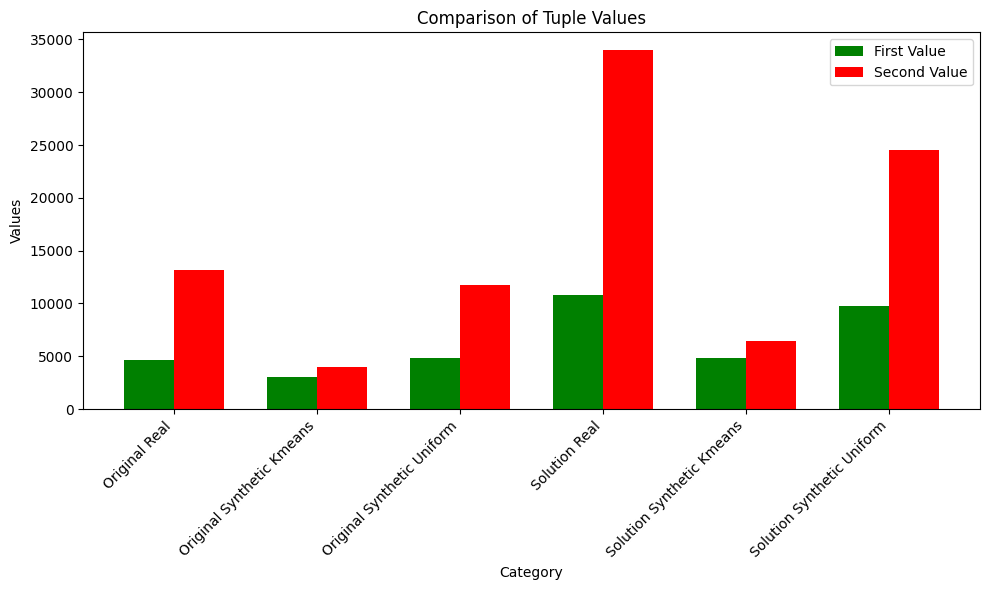

In [1110]:
# List of tuples
tuples = [original_real_output, 
          original_syntheticKmeans_output, 
          original_syntheticUniform_output,
          solution_real_output, 
          solution_syntheticKmeans_output, 
          solution_syntheticUniform_output]

# Labels for the x-axis
labels = ['Original Real', 
          'Original Synthetic Kmeans', 
          'Original Synthetic Uniform', 
          'Solution Real', 
          'Solution Synthetic Kmeans', 
          'Solution Synthetic Uniform']

# Number of bars for each group (1st and 2nd value in the tuple)
n_groups = len(tuples)

# Separate the tuple values into two lists: first_values (green) and second_values (red)
first_values = [t[0] for t in tuples]
second_values = [t[1] for t in tuples]

# Define the positions on the x-axis
index = np.arange(n_groups)

# Width of each bar
bar_width = 0.35

# Plotting the bars
fig, ax = plt.subplots(figsize=(10, 6))

# Bar for the first value in the tuple
bar1 = ax.bar(index, first_values, bar_width, color='green', label='First Value')

# Bar for the second value in the tuple, positioned next to the first one
bar2 = ax.bar(index + bar_width, second_values, bar_width, color='red', label='Second Value')

# Adding labels, title, and legend
ax.set_xlabel('Category')
ax.set_ylabel('Values')
ax.set_title('Comparison of Tuple Values')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

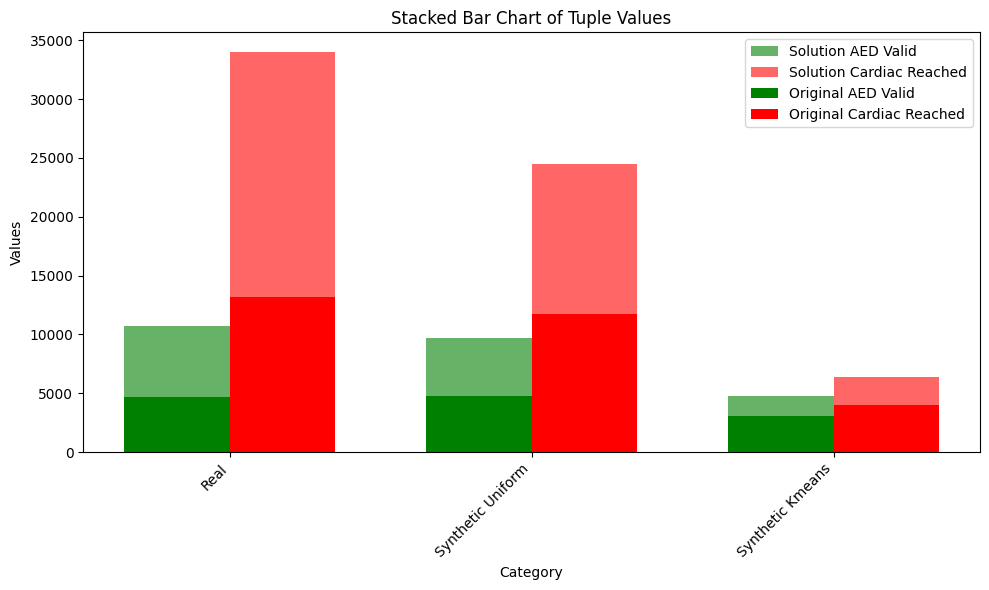

In [1114]:
# List of tuples
original_tuples = [original_real_output, 
                   original_syntheticUniform_output, 
                   original_syntheticKmeans_output]

solution_tuples = [solution_real_output, 
                   solution_syntheticUniform_output, 
                   solution_syntheticKmeans_output]

# Labels for the x-axis
labels = ['Real', 
          'Synthetic Uniform', 
          'Synthetic Kmeans']

# Number of groups
n_groups = len(original_tuples)

# Separate the tuple values into two lists: first_values (green) and second_values (red)
original_first_values = [t[0] for t in original_tuples]
original_second_values = [t[1] for t in original_tuples]

solution_first_values = [t[0] for t in solution_tuples]
solution_second_values = [t[1] for t in solution_tuples]

# Define the positions on the x-axis
index = np.arange(n_groups)

# Width of each bar
bar_width = 0.35

# Plotting the bars
fig, ax = plt.subplots(figsize=(10, 6))

# Bar for the "solution" tuple values
ax.bar(index - bar_width/2, solution_first_values, bar_width, color='green', alpha=0.6, label='Solution AED Valid')
ax.bar(index + bar_width/2, solution_second_values, bar_width, color='red', alpha=0.6, label='Solution Cardiac Reached')

# Bar for the "original" tuple values, plotted on top
ax.bar(index - bar_width/2, original_first_values, bar_width, color='green', alpha=1.0, label='Original AED Valid')
ax.bar(index + bar_width/2, original_second_values, bar_width, color='red', alpha=1.0, label='Original Cardiac Reached')

# Adding labels, title, and legend
ax.set_xlabel('Group')
ax.set_ylabel('Amount')
ax.set_title('Stacked Bar Chart of Valid ')
ax.set_xticks(index)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
#kan nog een paar simpele plots tonen, bar charts enzo van de verbetering, voor elke groep (synthetics en de originele met de
#originele setup, versus synthetics en de originele met de nieuwe setup). zowel aantal valid AED's als aantal card arrests saved.

In [ ]:
#je kan dat van de kosten/budget implementeren door gewoon NA de clustering het aantal AED's te verminderen, zoals ik heb gedaan
#zodanig dat het het aantal AED's dat verplaatst kan worden klopt. Dat zal dan niet helemaal juist zijn, maar bij benadering misschien wel?

Based on these metrics, you could say the performance of the AED's is improved almost threefold.

parameters te variëren:
-manier waarom AED's worden toegewezen (proportioneel of iets anders)
-X
-epsilon
-X constant overal of niet


In [ ]:
####################################################################################

pie chart van de verdeling van in welke provincies de herplaatste AED's staan, en welk address.

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point


AED_solution

# Create a GeoDataFrame from your coordinates
geometry = [Point(xy) for xy in zip(AED_solution['longitude'], AED_solution['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry)

# Load the shapefile of Belgian provinces
belgium_provinces = gpd.read_file('path_to_shapefile.shp')


In [ ]:
# Ensure both GeoDataFrames use the same coordinate reference system (CRS)
gdf = gdf.set_crs(belgium_provinces.crs, allow_override=True)

# Perform spatial join to find which province each point belongs to
joined_gdf = gpd.sjoin(gdf, belgium_provinces, how="left", op='within')

# The province names can now be found in a column, depending on the shapefile's attribute structure
df['province'] = joined_gdf['province_name_column']  # Adjust column name as necessary


In [453]:
tester_frame = AED_solution.iloc[0:100,]
tester_frame['province'] = None

C:\Users\eloua\AppData\Local\Temp\ipykernel_20008\2177141158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tester_frame['province'] = None


In [454]:
import pandas as pd
from geopy.geocoders import Nominatim
from time import sleep

# Initialize Nominatim API
geolocator = Nominatim(user_agent="province_locator")


# Function to reverse geocode and get province
def get_province(lat, lon):
    try:
        # Reverse geocode the lat/lon to get the address
        location = geolocator.reverse((lat, lon), language='en')
        # Introduce a delay to respect Nominatim's rate limit
        sleep(1)
        if location:
            address = location.raw.get('address', {})
            # Return the 'state' field from the address, which typically corresponds to the province
            return address.get('state', '')
    except Exception as e:
        print(f"Error fetching location for ({lat}, {lon}): {e}")
    return None

# Apply the function to each row in the DataFrame
tester_frame['province'] = tester_frame.apply(lambda row: get_province(row['latitude'], row['longitude']), axis=1)

# Display the updated DataFrame
print(tester_frame)


    cluster   latitude  longitude   aed_id address  number municipality  \
0       4.0  50.842920   4.311550  16589.0     NaN     NaN          NaN   
1       4.0  50.844530   4.367660  16590.0     NaN     NaN          NaN   
2       4.0  50.825370   4.330240  16591.0     NaN     NaN          NaN   
3       4.0  50.845550   4.387320  16592.0     NaN     NaN          NaN   
4       4.0  50.872094   4.344789  16593.0     NaN     NaN          NaN   
..      ...        ...        ...      ...     ...     ...          ...   
95      4.0  50.857560   4.363160  16684.0     NaN     NaN          NaN   
96      4.0  50.857260   4.327110  16685.0     NaN     NaN          NaN   
97      4.0  50.871040   4.369330  16686.0     NaN     NaN          NaN   
98      4.0  50.880620   4.340380  16687.0     NaN     NaN          NaN   
99      4.0  50.870970   4.379010  16688.0     NaN     NaN          NaN   

    postal_code province  
0           NaN           
1           NaN           
2           NaN   

C:\Users\eloua\AppData\Local\Temp\ipykernel_20008\1270442832.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tester_frame['province'] = tester_frame.apply(lambda row: get_province(row['latitude'], row['longitude']), axis=1)


In [462]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Load the shapefile (ensure to specify the correct path)
provinces_gdf = gpd.read_file('C:/Users/eloua/Desktop/belgium shapefile/be_1km.shp')

# Create a GeoDataFrame from your coordinates
geometry = [Point(xy) for xy in zip(tester_frame['longitude'], tester_frame['latitude'])]
gdf = gpd.GeoDataFrame(tester_frame, geometry=geometry)

# Ensure both GeoDataFrames use the same coordinate reference system (CRS)
gdf = gdf.set_crs(provinces_gdf.crs, allow_override=True)

# Perform spatial join to find which province each point belongs to
joined_gdf = gpd.sjoin(gdf, provinces_gdf, how="left", predicate='within')

# Inspect the result and column names to identify the correct column
print(joined_gdf.head())
print(joined_gdf.columns)

# Replace 'province_name_column' with the actual column name that contains the province data
# For example, if the column name is 'province', you should use:
# tester_frame['province'] = joined_gdf['province']

# Update with the correct column name after inspection
# For demonstration, let's assume the column is 'province'
tester_frame['province'] = joined_gdf['province']  # Replace 'province' with the correct column name


   cluster   latitude  longitude   aed_id address  number municipality  \
0      4.0  50.842920   4.311550  16589.0     NaN     NaN          NaN   
1      4.0  50.844530   4.367660  16590.0     NaN     NaN          NaN   
2      4.0  50.825370   4.330240  16591.0     NaN     NaN          NaN   
3      4.0  50.845550   4.387320  16592.0     NaN     NaN          NaN   
4      4.0  50.872094   4.344789  16593.0     NaN     NaN          NaN   

   postal_code province              geometry  index_right CELLCODE  \
0          NaN           POINT (4.312 50.843)          NaN      NaN   
1          NaN           POINT (4.368 50.845)          NaN      NaN   
2          NaN            POINT (4.33 50.825)          NaN      NaN   
3          NaN           POINT (4.387 50.846)          NaN      NaN   
4          NaN           POINT (4.345 50.872)          NaN      NaN   

   EOFORIGIN  NOFORIGIN  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN 

C:\Users\eloua\AppData\Local\Temp\ipykernel_20008\1870254202.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tester_frame['province'] = joined_gdf['province']  # Replace 'province' with the correct column name


In [ ]:
#shit werkt niet. Is misschien beter om de AED's te bekijken, met de cardiac arrests waarmee ze verbonden zijn, en dan bij de
#cardiac arrests kijken in welke provincie ze liggen.
#veel moeite voor iets dat eigenlijk maar een bonus is.

In [ ]:
#ipywidget shit ziet er wel echt nuttig uit. ook voor DBSCAN enzo, en voor de modellen zelf. het eindresultaat is dan de 
#output op de plot. probleem is wel dat het niet zeer vlot gaat lopen, want zijn zware berekeningen. Moet dan eigenlijk niet echt een slider
#zijn, maar intervallen waaruit je kan kiezen.

In [ ]:
#we can notive the following two facts from the plot:
#cities, where there originally already were a lot of AED's, receive even more AED's using our analysis.
#smaller towns, that originally received some AED's, do not receive any now (like Ooike and Zwalm in East-Flanders)
#the general strategy, in simple terms, is to place most AED's in bigger cities, and essentially ignore smaller towns. The denser the city, the more
#AED's get placed. One would need to analyse the population density of all towns, but it is likely that our method aligns with a simple cutoff 
#criterium like so: place an amount of AED's proportional to the population density of the area, if the population density is above X.

In [ ]:
#de provincies van de geplaatste AED's vinden. Kan door te kijken naar welke cardiac arrest ze in de buurt liggen.